In [1]:
using MAT
using NPZ
using Glob
using Dates
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Distributions
using DelimitedFiles

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14738452256438383535\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4996468363430991150\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14738452256438383535\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end;

#### Helper functions for rejection sampling

In [3]:
Norm(mu, sigma) = Distributions.Normal(mu, sigma);
Unif(a, b) = Distributions.Uniform(a, b);

function rejection_sample_mvn(num_samples, mu, sigma, current_samples, distance)
    
    i = 1
    rejectcount = 0
    distribution = MvNormal(vec(mu), vec(sigma))
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 2000)
        reset = false
        sample = rand(distribution, 1)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true; 
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            sample = transpose(sample)
            totalsample = vcat(totalsample, sample)
            i += 1
        end
    end
    
    if(rejectcount > 2000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end;

function rejection_sample_uniform(num_samples, a, b, current_samples, distance)
    
    i = 1
    rejectcount = 0
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 1000)
        reset = false
        sample = rand(Uniform(a,b), 1, 2)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            totalsample = vcat(totalsample, sample)
            i += 1
        end

    end
    
    if(rejectcount > 1000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end

function rejection_sampling_1d(prob_dist::Function, param1, param2, num_samples, dist_thresh)
    
    cnt = 0
    
    samples = []
    
    num_tries = 0
    max_tries = 1e6
    
    while cnt < num_samples
        
        if num_tries >= max_tries
            print("ERROR: Exceeded max. tries after sampling " * string(cnt) * "/" * string(num_samples))
            return nothing
        end
        
        new_sample = rand(prob_dist(param1, param2), 1)[1]
        
        if length(samples) > 0
            if sum(abs.(new_sample .- samples) .< dist_thresh) == 0
                push!(samples, new_sample)
                cnt += 1
            end
        else
            push!(samples, new_sample)
            cnt += 1
        end
        
        num_tries += 1
        
    end
    
    return samples
    
end;

#### Simulate cell sorting configurations

In [4]:
function generate_complete_sorting(num_red, num_green, num_r_cluster, num_g_cluster, seed)
    
    Random.seed!(seed)
    
    partitionsr = sample(1:num_red, num_r_cluster - 1, replace = false)
    partitionsr = sort(partitionsr)
    partitionsg = sample(1:num_green, num_g_cluster - 1, replace = false)
    partitionsg = sort(partitionsg)
    
    # place 'red' labelled cells
    amountperclusterr = []
    push!(amountperclusterr, partitionsr[1])
    for j in 2:(num_r_cluster - 1)
        push!(amountperclusterr, partitionsr[j] - partitionsr[j-1]);
    end
    push!(amountperclusterr, num_red - partitionsr[num_r_cluster-1])
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(num_red, 1)
    for i in 1:num_r_cluster
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Uniform(0.25, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterr[i], clustercenter, sigma, cellpos, 0.05)
    end
    
    # place 'green' labelled cells
    amountperclusterg = []
    push!(amountperclusterg, partitionsg[1])
    for j in 2:(num_g_cluster - 1)
        push!(amountperclusterg, partitionsg[j] - partitionsg[j-1])
    end
    push!(amountperclusterg, num_green - partitionsg[num_g_cluster-1])
    for i in 1:num_g_cluster
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Uniform(0.25, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterg[i], clustercenter, sigma, cellpos, 0.05)
    end
    celltypes = vcat(celltypes, (ones(num_green, 1) + ones(num_green, 1)))
    
    posfile = matopen("complete_sorting_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("complete_sorting_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_engulfment(num_red, num_green, num_g_cluster, seed)
    
    Random.seed!(seed)
    
    # By default 'red' cells are engulfed by 'green' cells
    
    amountperclusterg = []
    largeclustercenter = rand(Uniform(-1, 1), 1, 2)
    largeclustersigma = rand(Uniform(1.5, 2.5), 1, 2)
    
    if(num_g_cluster > 1)
        partitionsg = sample(1:num_green, num_g_cluster - 1, replace = false)
        partitionsg = sort(partitionsg)
        push!(amountperclusterg, partitionsg[1])
        for j in 2:(num_g_cluster - 1)
            push!(amountperclusterg, partitionsg[j] - partitionsg[j-1]);
        end
        push!(amountperclusterg, num_green - partitionsg[num_g_cluster-1])
        
    else
        push!(amountperclusterg, num_green);
    end
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(num_green, 1)
    for i in 1:num_g_cluster
        # restrict cluster center within larger 'green' cell cluster
        clustercenter = [rand(Uniform(largeclustercenter[1] - largeclustersigma[1], 
                    largeclustercenter[1] + largeclustersigma[1])), 
            rand(Uniform(largeclustercenter[2] - largeclustersigma[2],
                    largeclustercenter[2] + largeclustersigma[2]))]
        sigma = rand(Uniform(0.1, 0.5), 1, 2)
        cellpos = rejection_sample_mvn(amountperclusterg[i], clustercenter, sigma, cellpos, 0.05)
    end
    
    rcell = Array{Float64}(undef, 0, 2)
    # sample locations for placing 'red' labelled cells
    j = 1
    distribution = MvNormal(vec(largeclustercenter), vec(largeclustersigma))
    rejectioncount = 0
    while(j <= num_red && rejectioncount <= 2000)
        currentcell = rand(distribution, 1)
        currentcell = transpose(currentcell)
        reset = false
        count = 0
        for k in 1:num_green
            dist = sqrt((cellpos[k,1] - currentcell[1])^2 + (cellpos[k,2] - currentcell[2])^2)
            if(dist <= 0.2)
                count += 1
            end
            if(count >= 10)
                reset = true
                break
            end
        end
        for l in 1:(j-1)
            dist = sqrt((rcell[l,1] - currentcell[1])^2 + (rcell[l,2] - currentcell[2])^2)
            if(dist <= 0.05)
                reset = true
                rejectioncount += 1
                break
            end
        end
        if (reset)
            j -= 1
            rejectioncount += 1
        else
            rcell = vcat(rcell, currentcell)
        end
        j += 1
        if (rejectioncount > 2000)
            write(stderr, "WARNING: Exceeded threshold for max. rejections")
            break
        end
    end
    
    cellpos = vcat(rcell, cellpos)
    celltypes = ones(num_red)
    celltypes = vcat(celltypes, ones(num_green, 1) + ones(num_green, 1))
    
    posfile = matopen("engulfment_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("engulfment_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_checkerboard(num_green, num_red, num_rows, num_cols, seed)
    
    Random.seed!(seed);
    
    num_cluster = (num_rows * num_cols) ÷ 2;
    partitionsg = sample(1:num_green, num_cluster - 1, replace = false)
    partitionsg = sort(partitionsg)
    partitionsr = sample(1:num_red, num_cluster - 1, replace = false)
    partitionsr = sort(partitionsr)
    
    amountperclusterg = []
    push!(amountperclusterg, partitionsg[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterg, partitionsg[j] - partitionsg[j-1])
    end
    push!(amountperclusterg, num_green - partitionsg[num_cluster-1])
    
    amountperclusterr = []
    push!(amountperclusterr, partitionsr[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterr, partitionsr[j] - partitionsr[j-1])
    end
    push!(amountperclusterr, num_red - partitionsr[num_cluster-1])
    
    checkertopleft = rand(Uniform(-8, -5), 1, 2)
    checkerspacing = rand(Uniform(0.5, 1.0))
    
    # select cell type for top-left corner
    redvsgreen = rand((0,1))
    redcellpos = Array{Float64}(undef, 0, 2)
    greencellpos = Array{Float64}(undef, 0, 2)
    redcount = 1
    greencount = 1
    
    for i in 1:num_rows
        for j in 1:num_cols
            
            parity = iseven(i + j)
            minigausscenter = [checkertopleft[1] + i*checkerspacing, checkertopleft[2] + j*checkerspacing]
            
            if (redvsgreen == 1)
                if (parity)
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterg[greencount]))/10 + 0.05001), 1, 2)
                    greencellpos = rejection_sample_mvn(amountperclusterg[greencount], minigausscenter, 
                        sigma, greencellpos, 0.05)
                    greencount += 1
                else
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterr[redcount]))/10 + 0.05001), 1, 2)
                    redcellpos = rejection_sample_mvn(amountperclusterr[redcount], minigausscenter, 
                        sigma, redcellpos, 0.05)
                    redcount += 1
                end
            else
                if (parity)
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterr[redcount]))/10 + 0.05001), 1, 2)
                    redcellpos = rejection_sample_mvn(amountperclusterr[redcount], minigausscenter, 
                        sigma, redcellpos, 0.05)                 
                    redcount += 1
                else
                    sigma = rand(Uniform(0.05, abs(log(amountperclusterg[greencount]))/10 + 0.05001), 1, 2)
                    greencellpos = rejection_sample_mvn(amountperclusterg[greencount], minigausscenter, 
                        sigma, greencellpos, 0.05)
                    greencount += 1
                end
            end
            
        end
    end
    
    cellpos = vcat(redcellpos, greencellpos)
    celltypes = ones(num_red, 1)
    celltypes = vcat(celltypes, (ones(num_green, 1) + ones(num_green, 1)))
    
    posfile = matopen("checkerboard_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("checkerboard_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function generate_isolated_cells(num_red, num_green, seed)
    
    Random.seed!(seed)
    
    cellpos = Array{Float64}(undef, 0, 2)
    cellpos = rejection_sample_uniform(num_red, -9.5, 9.5, cellpos, 0.5)
    cellpos = rejection_sample_uniform(num_green, -9.5, 9.5, cellpos, 0.5)
    celltypes = ones(num_red, 1)
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)))
    
    posfile = matopen("isolated_cells_pos.mat", "w")
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("isolated_cells_types.mat", "w")
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes)
    
end

function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "dimgray")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "gold")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

#### Simulate Zebrafish skin pigmentation configurations

In [5]:
function generate_stripes(num_stripes, tot_num_cells, stripe_num_cells, stripe_width_mu, stripe_width_var, 
                          stripe_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if stripe_cell_type == 1
       o_type = 2 
    end
    
    stripe_pop = floor(Int, stripe_num_cells/num_stripes)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(stripe_num_cells) * stripe_cell_type
    
    for i in 1:num_stripes
        
        stripe_center = -10 - 2.5 + (i * 20/num_stripes)
        stripe_width = rand(Normal(stripe_width_mu, stripe_width_var), 1)[1]
        
        # Sample without rejection:
        stripe_x = rand(Uniform(-10, 10), stripe_pop)
        stripe_y = rand(Uniform(stripe_center-stripe_width, stripe_center+stripe_width), stripe_pop)
        
        # Sample with rejection:
        # stripe_x = rejection_sampling_1d(Unif, -10, 10, stripe_pop, 1e-3)
        # stripe_y = rejection_sampling_1d(Unif, stripe_center-stripe_width, stripe_center+stripe_width, 
        #    stripe_pop, 1e-3)
        
        cellpos = vcat(cellpos, hcat(stripe_x, stripe_y))
        
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - stripe_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - stripe_num_cells, 1))
    
    return (cellpos, celltypes)
    
end

function generate_sinusoidal_stripes(num_stripes, tot_num_cells, stripe_num_cells, stripe_width_var, amplitude,
                                     stripe_phase_var, sin_freq, stripe_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if stripe_cell_type == 1
       o_type = 2 
    end
    
    stripe_pop = floor(Int, stripe_num_cells/num_stripes)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(stripe_num_cells) * stripe_cell_type
    
    stripepos = Array{Float64}(undef, num_stripes, stripe_pop, 2)
    
    for i in 1:num_stripes
        
        stripe_center = -10 - 3 + (i * 20/num_stripes)
        
        # Sample without rejection:
        stripe_x = rand(Uniform(-10, 10), stripe_pop)
        stripe_y_noise = rand(Normal(0, stripe_width_var), stripe_pop)
        
        # Sample with rejection:
        # stripe_x = rejection_sampling_1d(Unif, -10, 10, stripe_pop, 1e-2)
        # stripe_y_noise = rejection_sampling_1d(Norm, stripe_width_mu, stripe_width_var, stripe_pop, 1e-2)
        
        phase_shift = rand(Normal(0, stripe_phase_var), 1)

        stripe_y = stripe_center*ones(stripe_pop) + stripe_y_noise + amplitude.*sin.(sin_freq.*stripe_x .+ phase_shift)
        
        cellpos = vcat(cellpos, hcat(stripe_x, stripe_y))
        
        stripepos[i,:,1] = stripe_x
        stripepos[i,:,2] = stripe_y
        
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - stripe_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - stripe_num_cells, 1))
    
    return (cellpos, celltypes, stripepos)
    
end

function generate_spots(num_spots, tot_num_cells, spot_num_cells, spot_width_mu, spot_width_var, 
                        spot_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if spot_cell_type == 1
       o_type = 2 
    end
    
    spot_pop = floor(Int, spot_num_cells/num_spots)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(spot_num_cells) * spot_cell_type
    
    for i in 1:num_spots
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Normal(spot_width_mu, spot_width_var), 1, 2)
        cellpos = rejection_sample_mvn(spot_pop, clustercenter, sigma, cellpos, 0.05)
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - spot_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - spot_num_cells, 1))
    
    #npzwrite("cellpositions.npz", cellpos)
    #npzwrite("celltypes.npz", celltypes)
    
    return (cellpos, celltypes)

end

function generate_fixed_spots(num_spots, tot_num_cells, spot_num_cells, spot_width_mu, spot_width_var, 
                              spot_cell_type, position_seed, param_seed)
    
    o_type = 1
    if spot_cell_type == 1
       o_type = 2 
    end
    
    spot_pop = floor(Int, spot_num_cells/num_spots)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(spot_num_cells) * spot_cell_type
    
    Random.seed!(position_seed)
    
    clustercenter = Array{Float64}(undef, num_spots, 2)
    
    for i in 1:num_spots
        clustercenter[i,:] = rand(Uniform(-9, 9), 1, 2)
    end
    
    Random.seed!(param_seed)
    
    for i in 1:num_spots
        sigma = rand(Normal(spot_width_mu, spot_width_var), 1, 2)
        cellpos = rejection_sample_mvn(spot_pop, clustercenter[i,:], sigma, cellpos, 0.05)
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - spot_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - spot_num_cells, 1))
    
    return (cellpos, celltypes)

end

function pairwise_euclidean(X)
    
    num_samples = size(X)[1]
    num_feats = size(X)[2]
    
    D = Array{Float64}(undef, num_samples, num_samples)
    
    for i in range(1, stop=num_samples)
        
        j = 1
        while (j < i)
            
            d = 0.0
            for k in range(1, stop=num_feats)
                d += (X[i,k] - X[j,k])^2
            end
            
            D[i,j] = sqrt(d) 
            D[j,i] = D[i,j]
            j += 1
            
        end
        
        D[i,i] = 0.0
        
    end
    
    return D
    
end;

function interparticle_dist(stripe_data)
    
    avg_cell_distance = 0.0

    num_cells = 0
    for s in range(1, stop=size(stripe_data)[1])

        D = pairwise_euclidean(stripe_data[s,:,:])

        avg_cell_distance += sum(sort(D, dims=2)[:,2])
        num_cells += size(D)[1]

    end

    avg_cell_distance /= num_cells
    
    return avg_cell_distance
    
end;

function interstripe_dist(stripe_data)
    
    avg_stripe_distance = 0.0
    num_cells = 0

    for s1 in range(1, stop=size(stripe_data)[1])

        for cid in range(1, stop=size(stripe_data)[2])

            cell_pos = stripe_data[s1, cid, :]

            all_distances = Array{Float64}(undef, (size(stripe_data)[1]-1)*size(stripe_data)[2])
            cnt = 0

            for s2 in range(1, stop=size(stripe_data)[1])

                if s2 != s1

                    for cid2 in range(1, stop=size(stripe_data)[2])

                        cell2_pos = stripe_data[s2, cid2, :]
                        d = 0.0
                        for k in range(1, stop=size(stripe_data)[3])
                            d += (cell_pos[k] - cell2_pos[k])^2
                        end

                        cnt += 1
                        all_distances[cnt] = sqrt(d)

                    end

                end

            end

            avg_stripe_distance += minimum(all_distances)
            num_cells += 1

        end

    end

    avg_stripe_distance /= num_cells
    
    return avg_stripe_distance
    
end;

#### Spotted pattern

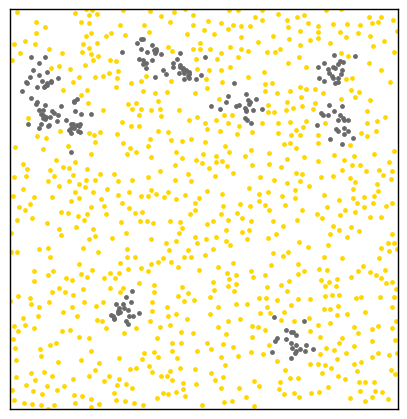

In [6]:
# num of spots = 10[*], 20, 50
# total number of cells = 1000
# number of cells in spots = 200
# spot size (mu) = 0.3[*], 0.5, 0.7
# spot size (var) = 0.01[*], 0.1

num_spots = 10
num_particles = 1000
num_red_particles = 200

spot_size_mu = 0.5
spot_size_sigma = 0.01 

rand_seed = Int(floor(datetime2unix(now())))

(cell_pos, cell_types) = generate_spots(num_spots, num_particles, num_red_particles, 
                                        spot_size_mu, spot_size_sigma, 1, rand_seed) 

plot_syn_data(cell_pos, cell_types);

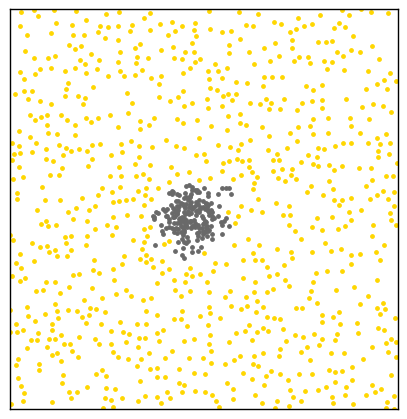

In [7]:
num_spots = 1
num_particles = 1000
num_red_particles = 200

spot_size_mu = 0.8   # 2.0
spot_size_sigma = 0.01  # 0.05

cluster_position_seed = 15
cluster_param_seed = Int(floor(datetime2unix(now())))

(cell_pos, cell_types) = generate_fixed_spots(num_spots, num_particles, num_red_particles, 
                                        spot_size_mu, spot_size_sigma, 1, 
                                        cluster_position_seed, cluster_param_seed) 

plot_syn_data(cell_pos, cell_types);

In [48]:
filename = "wspots_" * string(cluster_position_seed) * "_" * string(cluster_param_seed) * ".npz"
print("Writing file: " * filename)

file_dict = Dict("pos" => cell_pos, "types" => cell_types, "num_spots" => num_spots,  
                 "position_rand_seed" => cluster_position_seed, "param_rand_seed" => cluster_param_seed,
                 "num_particles" => num_particles, "num_spot_particles" => num_red_particles, 
                 "spot_size_mu" => spot_size_mu, "spot_size_sigma" => spot_size_sigma)

npzwrite("Wong_TDA_Proposal_Spots" * "/" * filename, file_dict)

Writing file: wspots_15_1631031719.npz

#### Stripe pattern

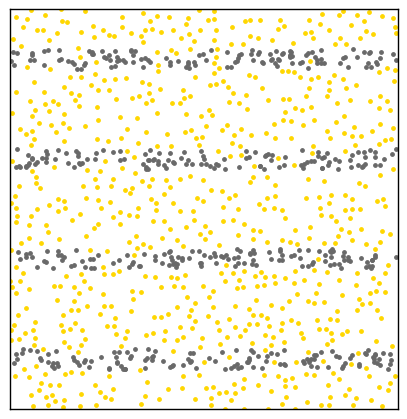

In [8]:
# num of stripes = 2, 4[*], 5, 10
# total number of cells: 1200
# number of cells in stripes: 500
# stripe width = 0.3, 0.5[*], 0.8, 1.0
# stripe variation = 0.01, 0.2

(cell_pos, cell_types) = generate_stripes(4, 1200, 500, 0.5, 0.01, 1, 123)   
plot_syn_data(cell_pos, cell_types);

#### Sinusoidal stripe pattern

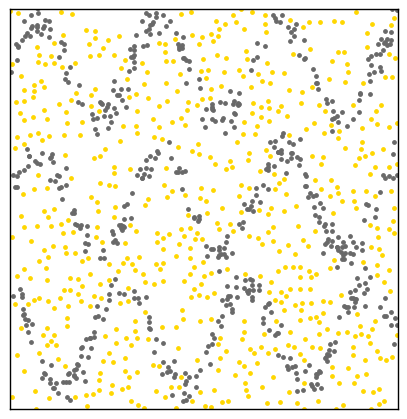

In [9]:
# num of stripes = 2, 4[*], 5
# total number of cells: 1200
# number of cells in stripes: 500
# stripe width (sigma) = 0.2, 0.4[*], 0.6
# phase variance = 0.01[*], 0.5, 2.5
# stripe frequency = 0.01, 0.5[*], 1.5, 2.0, 3.5

num_stripes = 3
num_particles = 1200
num_red_particles = 600

stripe_width_var = 0.5            # [0.1, 0.4, 0.7, 1.0]

sin_amp = 2.5                     # [0.5, 1.0, 2.0, 3.0]
sin_phase_var = 5.0
sin_omega = 1.0                   # [0.1, 1.0, 2.0, 4.0]
sin_freq = sin_omega/(2*π)

rand_seed = Int(floor(datetime2unix(now())))

(cell_pos, cell_types, stripe_data) = generate_sinusoidal_stripes(num_stripes, num_particles, num_red_particles, 
                                                        stripe_width_var, sin_amp, sin_phase_var, sin_omega,
                                                        1, rand_seed)   
plot_syn_data(cell_pos, cell_types);

In [10]:
filename = "wstripes_" * string(rand_seed) * ".npz"
print("Writing file: " * filename)

file_dict = Dict("pos" => cell_pos, "types" => cell_types, "random_seed" => rand_seed,
                 "num_stripes" => num_stripes, "num_particles" => num_particles, 
                "num_stripe_particles" => num_red_particles, "stripe_width_var" => stripe_width_var,
                "sin_amp" => sin_amp, "sin_phase_var" => sin_phase_var, "sin_omega" => sin_omega,
                "interparticle_dist_avg" => interparticle_dist(stripe_data), 
                "interstripe_dist_avg" => interstripe_dist(stripe_data))

Writing file: wstripes_1631136419.npz

Dict{String,Any} with 12 entries:
  "types"                  => [1.0; 1.0; … ; 2.0; 2.0]
  "sin_amp"                => 2.5
  "interstripe_dist_avg"   => 3.66954
  "sin_phase_var"          => 5.0
  "stripe_width_var"       => 0.5
  "num_stripes"            => 3
  "interparticle_dist_avg" => 0.240091
  "num_stripe_particles"   => 600
  "pos"                    => [7.72546 -4.43418; 2.13887 -3.56534; … ; 9.71242 …
  "sin_omega"              => 1.0
  "random_seed"            => 1631136419
  "num_particles"          => 1200

#### Parameter Sweep

In [61]:
A_arr = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0];
omega_arr = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5];
sigma_arr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0];

In [62]:
bash""" 
rm -rf stripe_width
mkdir stripe_width
"""

In [63]:
num_reps = 5

num_stripes = 3
num_particles = 1200
num_red_particles = 600

#stripe_width_var = 0.5

sin_amp = 0
sin_phase_var = 5.0
sin_omega = 1.0

parent_folder = "stripe_width"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    # perform param sweep
    for stripe_width_var in sigma_arr

        rand_seed = Int(floor(datetime2unix(now())))

        (cell_pos, cell_types, stripe_data) = generate_sinusoidal_stripes(num_stripes, num_particles, num_red_particles, 
                                                        stripe_width_var, sin_amp, sin_phase_var, sin_omega,
                                                        1, rand_seed)

        filename = storage_folder * "/wstripes_" * string(rand_seed) * ".npz"

        file_dict = Dict("pos" => cell_pos, "types" => cell_types, "random_seed" => rand_seed,
                     "num_stripes" => num_stripes, "num_particles" => num_particles, 
                    "num_stripe_particles" => num_red_particles, "stripe_width_var" => stripe_width_var,
                    "sin_amp" => sin_amp, "sin_phase_var" => sin_phase_var, "sin_omega" => sin_omega,
                    "interparticle_dist_avg" => interparticle_dist(stripe_data),
                    "interstripe_dist_avg" => interstripe_dist(stripe_data))

        #npzwrite(filename, file_dict)

        sleep(1)

    end
    
end

#### Pairwise wasserstein distance computation

1
1


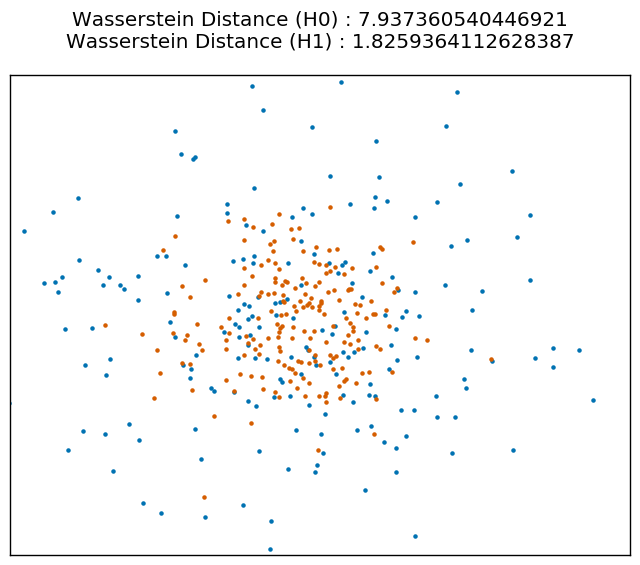

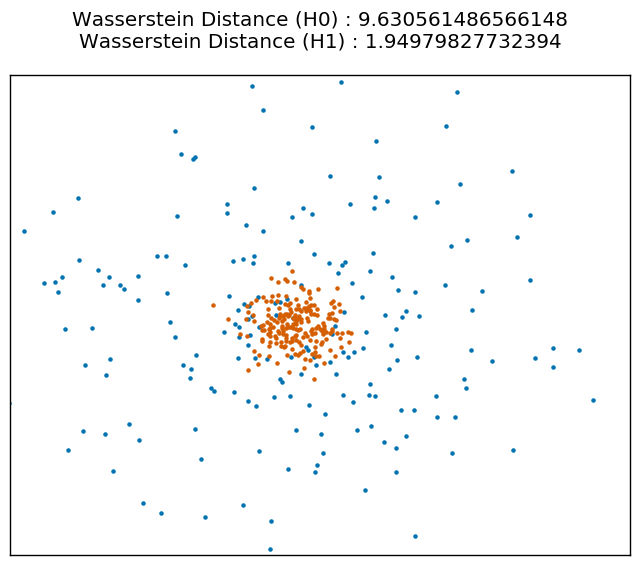

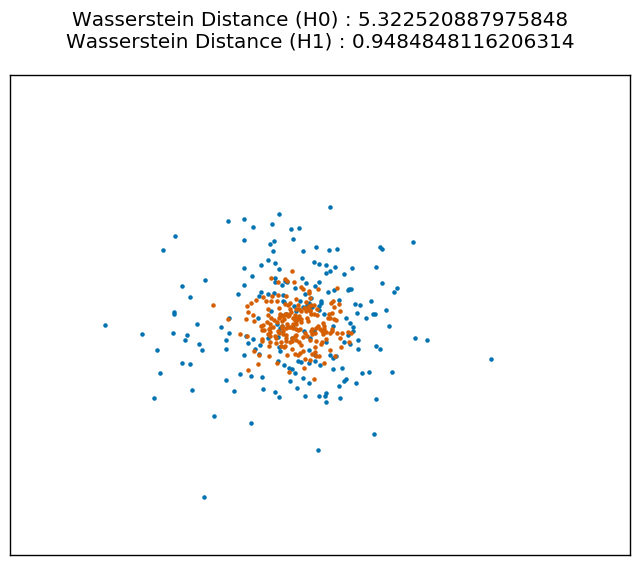

1


In [107]:
folder = "Wong_TDA_Proposal_Single_Spot"
filepaths = glob("*.npz", folder)

file_pairs = []

for filepath_1 in filepaths
    for filepath_2 in filepaths
   
        if filepath_1 != filepath_2
            
            f1_tstamp = split(split(split(filepath_1, "/")[end], ".")[1], "_")[end]
            f2_tstamp = split(split(split(filepath_2, "/")[end], ".")[1], "_")[end]
            filepair = f1_tstamp * "," * f2_tstamp
            filepair_rev = f2_tstamp * "," * f1_tstamp
            
            if filepair in file_pairs
                
                continue
                
            else
                
                push!(file_pairs, filepair)
                push!(file_pairs, filepair_rev)
                
                f1 = npzread(filepath_1)
                f2 = npzread(filepath_2)
                
                #plot_syn_data(f1["pos"], f1["types"]);
                #plot_syn_data(f2["pos"], f2["types"]);
                
                f1_xpos = f1["pos"][:,1]
                f1_ypos = f1["pos"][:,2]
                
                f2_xpos = f2["pos"][:,1]
                f2_ypos = f2["pos"][:,2]
                
                f1_xpos_type1 = f1_xpos[findall(f1["types"] .== 1)]
                f1_ypos_type1 = f1_ypos[findall(f1["types"] .== 1)]
                f1_pos_type1 = hcat(f1_xpos_type1, f1_ypos_type1)
                
                f2_xpos_type1 = f2_xpos[findall(f2["types"] .== 1)]
                f2_ypos_type1 = f2_ypos[findall(f2["types"] .== 1)]
                f2_pos_type1 = hcat(f2_xpos_type1, f2_ypos_type1)
                
                pers_diag_1 = eirene(transpose(f1_pos_type1), model="pc", maxdim=1)
                barcode_1_H0 = barcode(pers_diag_1, dim=0)
                barcode_1_H1 = barcode(pers_diag_1, dim=1)
                
                pers_diag_2 = eirene(transpose(f2_pos_type1), model="pc", maxdim=1)
                barcode_2_H0 = barcode(pers_diag_2, dim=0)
                barcode_2_H1 = barcode(pers_diag_2, dim=1)
                
                wass_H0 = wasserstein_distance(barcode_1_H0, barcode_2_H0, p=2, q=2)
                wass_H1 = wasserstein_distance(barcode_1_H1, barcode_2_H1, p=2, q=2)
                
                title_str = ""
                title_str *= "Wasserstein Distance (H0) : " * string(wass_H0) * "\n"
                title_str *= "Wasserstein Distance (H1) : " * string(wass_H1) * "\n"
                
                figure()
                scatter(f1_pos_type1[:,1], f1_pos_type1[:,2], s=5, color="#0072B2")
                scatter(f2_pos_type1[:,1], f2_pos_type1[:,2], s=5, color="#D55E00")
                xlim([-10, 10])
                ylim([-10, 10])
                xticks([])
                yticks([])
                title(title_str)
                show()
                
            end
            
            
        end
        
    end
    
end

#### Cell Sorting

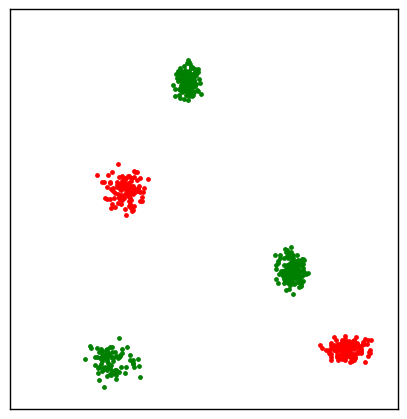

In [4]:
(cell_pos, cell_types) = generate_complete_sorting(250, 350, 2, 4, 67)
plot_syn_data(cell_pos, cell_types);

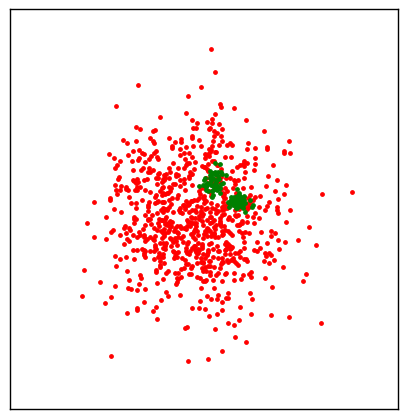

In [5]:
cellpos, celltypes = generate_engulfment(800, 100, 2, 79)
plot_syn_data(cellpos, celltypes);

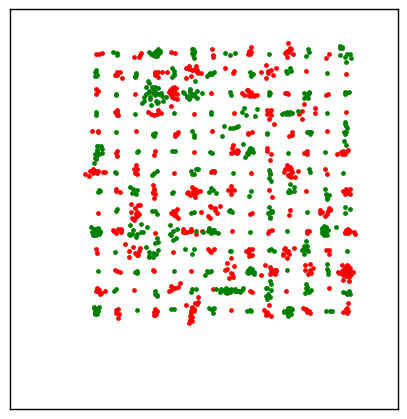

In [6]:
(cell_pos, cell_types) = generate_checkerboard(500, 500, 14, 14, 83)
plot_syn_data(cell_pos, cell_types);

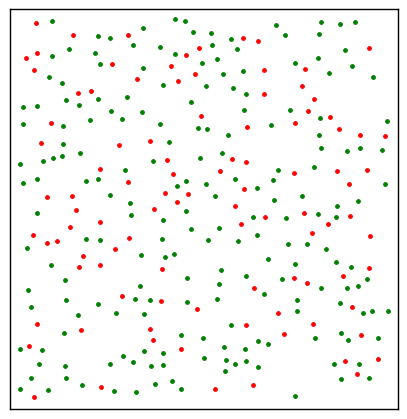

In [7]:
(cell_pos, cell_types) = generate_isolated_cells(100, 200, 89)
plot_syn_data(cell_pos, cell_types);